## Library import

**YOU NEED TO USE PYTHON 3.7-3.9**

In [1]:
!pip install pandas==1.4.2
!pip install numpy==1.21.1
!pip install scikit-learn==1.0.2
!pip install matplotlib==3.6.3
!pip install plotly==5.13.0
!pip install shap==0.41.0
!pip install xgboost==1.6.1
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#sns.set_theme()

from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBRegressor, DMatrix
from sklearn.linear_model import LogisticRegression

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.metrics import classification_report,confusion_matrix
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, recall_score, precision_score
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
import shap


# Useful functions

In [3]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()

    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

# Lung cancer risk estimation

In this notebook, we will try to predict lung cancer based on two datasets: 
- PLCO dataset: with 150 000 points and 219 descriptors for each point
- NLST dataset : 50 000 points and 322 descriptors for each point

In [4]:
plco_file = '/Users/plbenveniste/Documents/Lung-cancer-risk/package-plco-594/Lung/lung_data_nov18_d070819.csv'
plco = pd.read_csv(plco_file)
print(plco.shape)
nlst_file = '/Users/plbenveniste/Documents/Lung-cancer-risk/package-nlst-814.2021-07-27/participant_data_d100517.csv'
nlst = pd.read_csv(nlst_file)
print(nlst.shape)

(154887, 219)
(53452, 324)


## Removal of non-smokers

Because our target populations and because smoking is such a high contributing risk factor we decide to keep only the participants to PLCO who are smokers or former-smokers. Also, this removes a bias as our testing dataset NLST only contains smokers and former-smokers.

`cig_stat == 1 or 2`

In [5]:
print("Total number of participant to PLCO:",len(plco))
plco = plco.loc[plco.cig_stat > 0]
print("Numbers of smokers and former-smokers:",len(plco))

Total number of participant to PLCO: 154887
Numbers of smokers and former-smokers: 80668


## Censored data

Both our dataset contains subjects who are not interesting to our study. We decided to remove:

- Patients who died because of something else :

    Their case can add bias to the model as they might have been more susceptible of developping lung cancer because of having poor health
    
- Remove all who have not been followed enough through the study

    We will explain how the minimum reauired time was computed

In [6]:
#For PLCO
plco_nb_ini = len(plco)
plco = plco.loc[plco['d_dthl']!=0]
plco_nb_aft = len(plco)
print("Removed " + str(round(((1.0-plco_nb_aft/plco_nb_ini)*100),2)) + " % of PLCO")

#For NLST
#nlst_nb_ini = len(nlst)
#nlst = nlst.loc[nlst['finaldeathlc']!=0]
#nlst_nb_aft = len(nlst)
#print("Removed " + str(round(((1.0-nlst_nb_aft/nlst_nb_ini)*100),2)) + " % of NLST")

Removed 30.19 % of PLCO


Let's look at the distribution of the length of study of the patients to select a length which is appropriate for everyone.

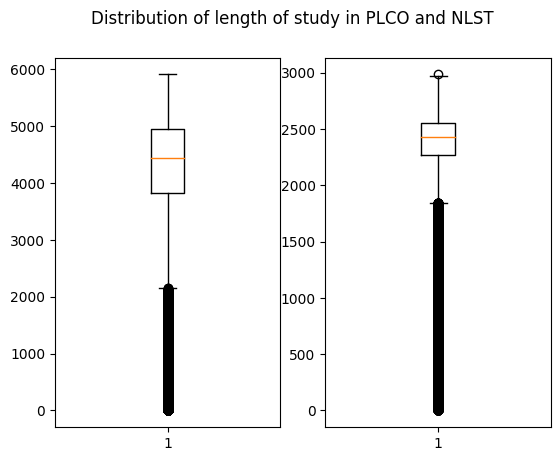

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of length of study in PLCO and NLST ')
ax1.boxplot(plco['lung_exitdays'])
ax2.boxplot(nlst['fup_days'])
plt.show()

We only keep participant who were studied longer than 2100 days (5.75 years) if they were never diagnosed with cancer and those who were diagnosed with cancer when ever. On the other hand, we don't mind keeping participants who stayed longer as they bring more information to the study. 

In [8]:
plco = plco[((plco['lung_exitstat']!=1) & (plco['lung_exitdays']>2100)) | (plco['lung_exitstat']==1)]
plco_nb_final = len(plco)
print("Removed " + str(round(((1.0-plco_nb_final/plco_nb_ini)*100),2)) + " % of PLCO")
print(plco_nb_final)

#nlst = nlst[((nlst['scr_group']!=1) & (nlst['fup_days']>2100)) | (nlst['scr_group']==1)]
#nlst_nb_final = len(nlst)
#print("Removed " + str(round(((1.0-nlst_nb_final/nlst_nb_ini)*100),2)) + " % of NLST")

Removed 31.62 % of PLCO
55161


## Pre-Processing


We first extract the same features from both dataset and keep only those which we have seen are risk factors related to lung cancer.

In both dataset, we can find different informations but the dataset may be not be in the same format or described the same descriptors. In the following we will use the name of the PLCO features.


For the race feature, On the PLCO dataset, we have: 

`
1="White, Non-Hispanic" 
2="Black, Non-Hispanic" 
3="Hispanic"
4="Asian"
5="Pacific Islander" 
6="American Indian" 
7="Missing"
`

And, for the NLST dataset, we have: 

`
1="White"
2="Black or African-American"
3="Asian"
4="American Indian or Alaskan Native"
5="Native Hawaiian or Other Pacific Islander" 
6="More than one race"
7="Participant refused to answer"
95="Missing data form - form is not expected to ever be completed"
96="Missing - no response"
98="Missing - form was submitted and the answer was left blank"
99="Unknown/ decline to answer"
`

So, we will keep: 

`
1="White or hispanic" 
2="Black" 
4="Asian"
5="Pacific Islander" 
6="American Indian" 
7="Missing"
`

In [9]:
#For PLCO
plco = plco[["age", "sex", "height_f", "weight_f", "race7", "ssmokea_f", "cig_stat", "cigar", "pipe", "pack_years", "smokea_f", "cigpd_f","cig_years", "bronchit_f",
                "diabetes_f", "emphys_f", "hearta_f", "hyperten_f", "stroke_f", "lung_fh","lung_cancer"
            ]]
plco["race7"] = plco["race7"].replace(3,1)
print(plco.shape)

#For NLST
nlst2 = nlst[["age", "gender", "height",  "weight", "race", "age_quit", "cigsmok", "cigar", "pipe", "pkyr", "smokeage", "smokeday", "smokeyr", "agechro", "diagdiab",
        "diagemph", "diaghear", "diaghype", "diagstro",
        ]]
nlst2["lung_fh"] = nlst[["famfather","fammother", "famchild", "famsister", "fambrother"]].max(axis=1)
nlst2["can_scr"] = 1 * (nlst["can_scr"] > 0)
nlst["race"] = nlst["race"].replace([3,4,6,95,96,98,99],[4,6,7,7,7,7,7])
nlst=nlst2
print(nlst.shape)

(55161, 21)
(53452, 21)


Now we change the column names to have two matching datasets.

In [10]:
change_columns = {
        "age": "age",
        "gender": "sex", 
        "height": "height_f",
        "weight": "weight_f",
        "race": "race7",
        "age_quit": "ssmokea_f",
        "cigsmok": "cig_stat",
        "cigar": "cigar",
        "pipe": "pipe",
        "pkyr": "pack_years",
        "smokeage": "smokea_f",
        "smokeday": "cigpd_f",
        "smokeyr": "cig_years",
        "agechro": "bronchit_f",
        "diagdiab": "diabetes_f",
        "diagemph": "emphys_f",
        "diaghear": "hearta_f",
        "diaghype": "hyperten_f",
        "diagstro": "stroke_f",
        "can_scr": "lung_cancer",
        "lung_fh": "lung_fh"
}
nlst = nlst.rename(columns=change_columns)

We add the `bmi` column by computing it from other columns. 

In [11]:
plco.loc[:, 'bmi'] = plco['weight_f'] / plco['height_f']**2 * 703
nlst['bmi'] = nlst['weight_f'] / nlst['height_f']**2 * 703

Finally, we extract the feature columns and the output column for both the training and testing sets.

In [12]:
x_plco = plco.drop(columns= ['lung_cancer'])
y_plco = plco['lung_cancer']
x_nlst = nlst.drop(columns=['lung_cancer'])
y_nlst = nlst['lung_cancer']

## Logistic regression

A first test was performed to use logistic regression in order to predict lung cancer risk. 
The downside of this model is that it doesn't accept `NaN` values. 
We first have to remove them.

In [13]:
#Data pre-processing
plco_no_na = plco.dropna()
plco_feats = plco_no_na.drop(columns= ['lung_cancer'])
lung_cancer = plco_no_na['lung_cancer']
plco_train, plco_val, y_train, y_val = train_test_split(plco_feats, lung_cancer)

nlst_no_na = nlst.dropna()
nlst_feats = nlst_no_na.drop(columns=['lung_cancer'])
nlst_true = nlst_no_na['lung_cancer']

#Model initialisation
clf = LogisticRegression(random_state=0, max_iter=2000).fit(plco_train, y_train)

#Model prediction
plco_pred = clf.predict_proba(plco_val)
print('The ROC AUC SCORE on the PLCO val database is : ', roc_auc_score(y_val, plco_pred[:, 1]))

nlst_pred = clf.predict_proba(nlst_feats)
print('The ROC AUC SCORE on the NLST database is : ', roc_auc_score(nlst_true, nlst_pred[:, 1]))

The ROC AUC SCORE on the PLCO val database is :  0.8044864088123354
The ROC AUC SCORE on the NLST database is :  0.6462538335354112


We plot the reliability diagram (also called probality calibration curves) for the validation set and compare the results, with and without calibration.

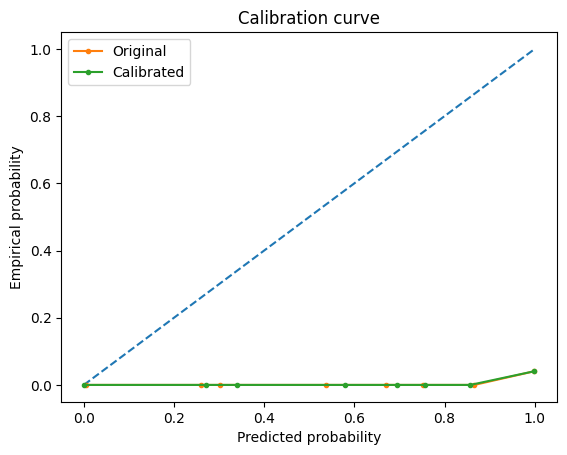

In [14]:
#reliability on the NLST dataset (using only the training set)
probs = plco_pred = clf.predict_proba(nlst_feats)[:, 1]
fop, mpv = calibration_curve(nlst_true, probs, n_bins=10, normalize=True)

#Now with calibration on the NLST dataset using the PLCO validation set
calibrated = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated.fit(plco_val, y_val)
probs_calib = calibrated.predict_proba(nlst_feats)[:, 1]
fop_calib, mpv_calib = calibration_curve(nlst_true, probs_calib, n_bins=10, normalize=True)

#Relianility diagram
plt.title('Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel("Empirical probability")
plt.xlabel("Predicted probability")
plt.plot(mpv, fop, marker='.',label='Original')
plt.plot(mpv_calib, fop_calib, marker='.',label='Calibrated')
plt.legend()
plt.show()

# MODEL 

To build a machine learning model able to predict the risk of lung cancer, we train an XGBoost on the pre-processed PLCO dataset. 
We then test the model on an external dataset: the NLST dataset.

Column to predict : lung_cancer

**Optimization**

Instead of doing a Grid Search to optimize our parameters, we will use a Package from scikit-learn named skopt. 

**Metrics**

We want to maximise the recall.
We will take as a metric the $F_\beta$ score with $\beta = 2$.
For each model, we will also look at the ROC-AUC score to give us an idea of the preicision. 

**Calibration**

To see if our models are calibrated, we will use a CVcalibration from the scikit learn package.

**Interpretability**

After doing all of this, we will try to interpret our model by looking at the Shapley Values. These will give us an idea of which features are the most important ones. 


In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_plco, y_plco, test_size=0.3)
x_test,y_test = x_nlst, y_nlst

In [16]:
# Setting the basic regressor
reg = xgb.XGBClassifier(random_state=0, 
                        booster='gbtree', 
                        objective='binary:logistic', 
                        eval_metric='aucpr',
                        tree_method='exact')

# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(x_train, y_train))

search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 10),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'),
                 'n_estimators': Integer(50, 1000),
                 'scale_pos_weight': (1, 1000, 'log-uniform'),
   }

opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                                 
                    cv=cv_strategy,                                           
                    n_iter=200,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*60*2)          # We impose a time limit (7 hours)

best_params = report_perf(opt, x_train, y_train,'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_regression took 5283.81 seconds,  candidates checked: 32, best CV score: 0.950 ± 0.001
Best parameters:
OrderedDict([('colsample_bytree', 0.6291786732768406),
             ('learning_rate', 0.01),
             ('max_depth', 4),
             ('n_estimators', 50),
             ('scale_pos_weight', 2),
             ('subsample', 0.551302100320767)])



Now we train the model on all the features and evaluate their performance:

In [17]:
model_all_features = xgb.XGBClassifier(random_state=0, 
                        booster='gbtree', 
                        objective='binary:logistic', 
                        eval_metric='aucpr',
                        tree_method='exact',
                        **best_params)
model_all_features.fit(x_train, y_train)

y_val_pred = model_all_features.predict(x_val)
y_val_prob_pred = model_all_features.predict_proba(x_val)
print("---------- VALIDATION DATASET ------------")
print(classification_report(y_val,y_val_pred))
print("ROC AUC score validation", roc_auc_score(y_val, y_val_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_val, y_val_pred))
print("Precision score ", precision_score(y_val, y_val_pred))
print("Recall score ", recall_score(y_val, y_val_pred))

y_test_pred = model_all_features.predict(x_test)
y_test_prob_pred = model_all_features.predict_proba(x_test)
print("---------- TESTING DATASET ------------")
print(classification_report(y_test,y_test_pred))
print("ROC AUC score validation", roc_auc_score(y_test, y_test_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_test, y_test_pred))
print("Precision score ", precision_score(y_test, y_test_pred))
print("Recall score ", recall_score(y_test, y_test_pred))

---------- VALIDATION DATASET ------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15736
           1       0.52      0.04      0.07       813

    accuracy                           0.95     16549
   macro avg       0.74      0.52      0.52     16549
weighted avg       0.93      0.95      0.93     16549

ROC AUC score validation 0.8219146826699584
F_1 score  0.06674338319907942
Precision score  0.5178571428571429
Recall score  0.03567035670356704
---------- TESTING DATASET ------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     51394
           1       0.12      0.11      0.12      2058

    accuracy                           0.94     53452
   macro avg       0.54      0.54      0.54     53452
weighted avg       0.93      0.94      0.93     53452

ROC AUC score validation 0.6931067428055284
F_1 score  0.11606912561258706
Precision score  0.12369433754810336
Recall

We look at which features are important:

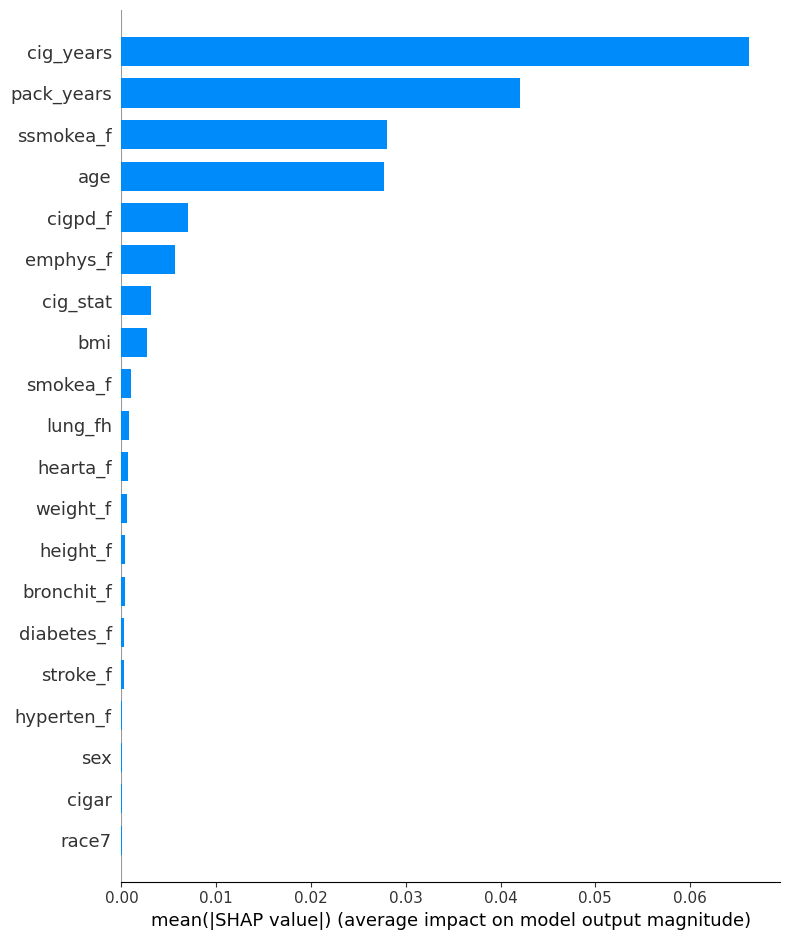

In [18]:
#To see importance over the entire dataset
shap_values = shap.Explainer(model_all_features).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

We then select the features to extract:

In [28]:
#Feature selection
columns_to_keep = ['age', 'ssmokea_f', 'cig_stat', 'pack_years', 'smokea_f', 
                  'cig_years', 'lung_fh', 'bmi'] 
x_plco = x_plco[columns_to_keep]
x_nlst = x_nlst[columns_to_keep]

x_train, x_val, y_train, y_val = train_test_split(x_plco, y_plco, test_size=0.3)
x_test,y_test = x_nlst, y_nlst

Now we train the model on the reduced list of features:

[0]	validation_0-aucpr:0.18777	validation_1-aucpr:0.17432
[1]	validation_0-aucpr:0.20581	validation_1-aucpr:0.18094
[2]	validation_0-aucpr:0.22403	validation_1-aucpr:0.19571
[3]	validation_0-aucpr:0.22949	validation_1-aucpr:0.20288
[4]	validation_0-aucpr:0.23640	validation_1-aucpr:0.20545
[5]	validation_0-aucpr:0.23482	validation_1-aucpr:0.20375
[6]	validation_0-aucpr:0.23697	validation_1-aucpr:0.20462
[7]	validation_0-aucpr:0.23778	validation_1-aucpr:0.20873
[8]	validation_0-aucpr:0.23812	validation_1-aucpr:0.20805
[9]	validation_0-aucpr:0.23903	validation_1-aucpr:0.20777
[10]	validation_0-aucpr:0.23889	validation_1-aucpr:0.20826
[11]	validation_0-aucpr:0.23976	validation_1-aucpr:0.20698
[12]	validation_0-aucpr:0.23967	validation_1-aucpr:0.20743
[13]	validation_0-aucpr:0.23971	validation_1-aucpr:0.20669
[14]	validation_0-aucpr:0.24252	validation_1-aucpr:0.20964
[15]	validation_0-aucpr:0.24253	validation_1-aucpr:0.21129
[16]	validation_0-aucpr:0.24266	validation_1-aucpr:0.21124
[17]	va

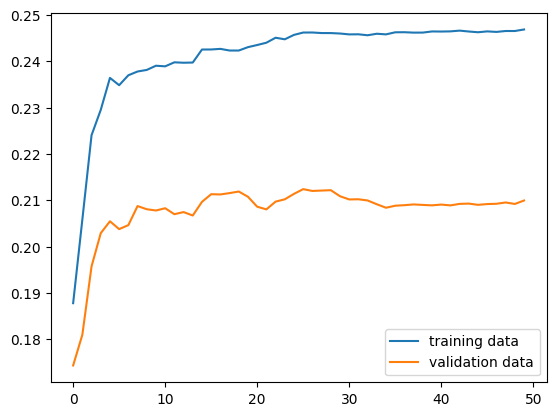

In [29]:
model_final = xgb.XGBClassifier(random_state=0, 
                        booster='gbtree', 
                        objective='binary:logistic', 
                        eval_metric='aucpr',
                        tree_method='exact',
                        **best_params)
model_final.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

train_history = model_final.evals_result()

plt.plot(train_history["validation_0"]["aucpr"], label="training data")
plt.plot(train_history["validation_1"]["aucpr"], label="validation data")
plt.legend()
plt.show()

In [30]:
y_val_pred = model_final.predict(x_val)
y_val_prob_pred = model_final.predict_proba(x_val)
print("---------- VALIDATION DATASET ------------")
print(classification_report(y_val,y_val_pred))
print("ROC AUC score validation", roc_auc_score(y_val, y_val_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_val, y_val_pred))
print("Precision score ", precision_score(y_val, y_val_pred))
print("Recall score ", recall_score(y_val, y_val_pred))

y_test_pred = model_final.predict(x_test)
y_test_prob_pred = model_final.predict_proba(x_test)
print("---------- TESTING DATASET ------------")
print(classification_report(y_test,y_test_pred))
print("ROC AUC score validation", roc_auc_score(y_test, y_test_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_test, y_test_pred))
print("Precision score ", precision_score(y_test, y_test_pred))
print("Recall score ", recall_score(y_test, y_test_pred))

---------- VALIDATION DATASET ------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15727
           1       0.35      0.06      0.10       822

    accuracy                           0.95     16549
   macro avg       0.65      0.53      0.54     16549
weighted avg       0.92      0.95      0.93     16549

ROC AUC score validation 0.8191261653173822
F_1 score  0.09842931937172775
Precision score  0.3533834586466165
Recall score  0.057177615571776155
---------- TESTING DATASET ------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     51394
           1       0.11      0.12      0.12      2058

    accuracy                           0.93     53452
   macro avg       0.54      0.54      0.54     53452
weighted avg       0.93      0.93      0.93     53452

ROC AUC score validation 0.6881842869959485
F_1 score  0.11770157553290084
Precision score  0.112488928255093
Recall 

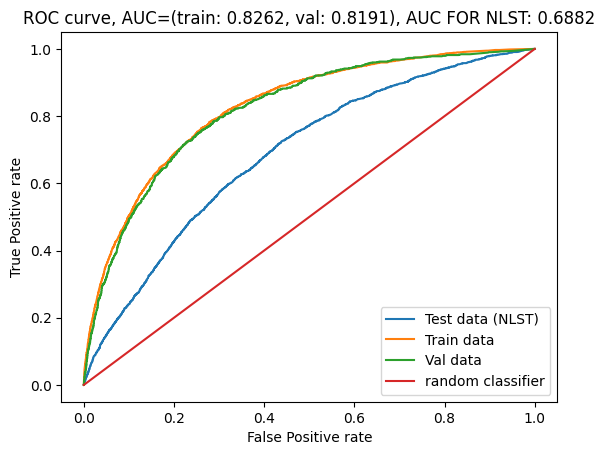

In [31]:
y_train_pred = model_final.predict_proba(x_train)
y_val_pred = model_final.predict_proba(x_val)
y_test_pred = model_final.predict_proba(x_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred[:, 1])
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_val = auc(fpr_val, tpr_val)
auc_train = auc(fpr_train, tpr_train)

plt.title(f"ROC curve, AUC=(train: {auc_train:.4f}, val: {auc_val:.4f}), AUC FOR NLST: {auc_test:.4f}")
plt.plot(fpr_test, tpr_test, label="Test data (NLST)")
plt.plot(fpr_train, tpr_train, label="Train data")
plt.plot(fpr_val, tpr_val, label="Val data")
plt.plot([0, 1], [0,1], label="random classifier")
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.show()

### Calibration

Here we look at the calibration curve:

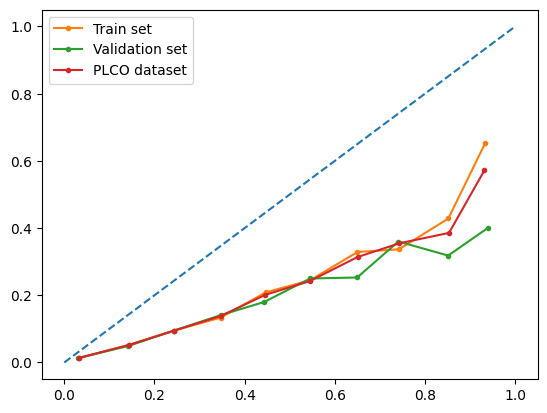

In [32]:
# predict probabilities
probs_train = model_final.predict_proba(x_train)[:, 1]
probs_val = model_final.predict_proba(x_val)[:, 1]
probs_plco = model_final.predict_proba(x_plco)[:, 1]
# reliability diagram
fop_train, mpv_train = calibration_curve(y_train, probs_train, n_bins=10, normalize=True)
fop_val, mpv_val = calibration_curve(y_val, probs_val, n_bins=10, normalize=True)
fop_plco, mpv_plco = calibration_curve(y_plco, probs_plco, n_bins=10, normalize=True)

# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv_train, fop_train, marker='.', label='Train set')
pyplot.plot(mpv_val, fop_val, marker='.', label='Validation set')
pyplot.plot(mpv_plco, fop_plco, marker='.', label='PLCO dataset')
pyplot.legend()
pyplot.show()

We now calibrate the XGBoost model over the plco dataset and see how it does on the NLST dataset

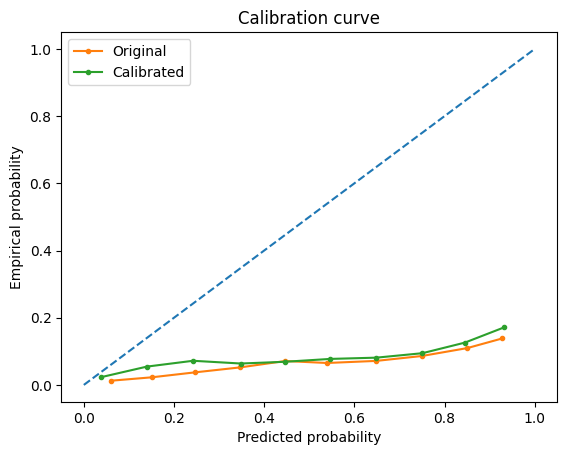

In [33]:
#reliability on the NLST dataset (using only the training set)
probs = model_final.predict_proba(x_test)[:, 1]
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)

#Now with calibration on the NLST dataset using the PLCO validation set
calibrated = CalibratedClassifierCV(model_final, method='sigmoid', cv=5)
calibrated.fit(x_plco, y_plco)
probs_calib = calibrated.predict_proba(x_test)[:, 1]
fop_calib, mpv_calib = calibration_curve(y_test, probs_calib, n_bins=10, normalize=True)

#Relianility diagram
plt.title('Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel("Empirical probability")
plt.xlabel("Predicted probability")
plt.plot(mpv, fop, marker='.',label='Original')
plt.plot(mpv_calib, fop_calib, marker='.',label='Calibrated')
plt.legend()
plt.show()

### Explainability

We can also view the explainability of each predictions based on the following code:

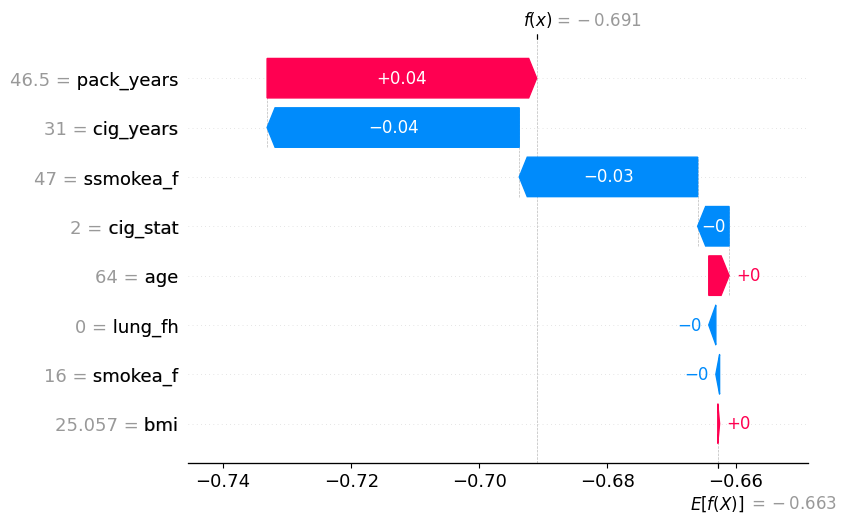

In [34]:
model_final.fit(x_train, y_train)
explainer = shap.Explainer(model_final)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[4])